In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine Tune Imagen Model

## Overview

Imagen model is a text-to-image model from Google AI, trained on a massive dataset of images. You can generate images for different scenarios such as ads, photo shoots, blog post images, and etc. Sometimes, you want to personalize the model to achieve your goals. You can fine tune Imagen by using 5-10 images to do that. This notebook is to show you how to do it.

The notebook is structured as follows:

1. We check all the prerequisites to make sure you have all the gcp resources ready for fine-tuning.

2. We show you how to kick off an imagen fine-tuning pipeline.

3. After the pipeline get kicked off, we show you how to poll the job state.

4. Once the job successfully finishes running, we show you how to get the fine-tuned model endpoint.

5. In the end, we show you how to generate images by querying the fine-tuned model.

## Pre-requisites
- Quota check: if you don't have enough, go to Quotas page and increase quota for  the following metric and region: metric:aiplatform.googleapis.com/restricted_image_training_a2_cpus and region:us-east4
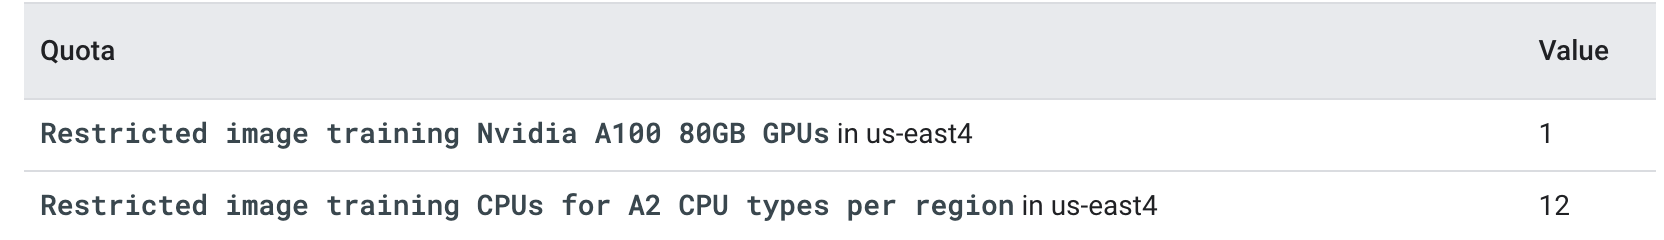

- Training images setup:
  - Create a Cloud Storage bucket. Upload local files to the Cloud Storage bucket (JPEG, PNG, GIF, or BMP files).

  - Create a CSV input file that lists the Cloud Storage location of the fine-tuning images.

- Performance and limitations
  - Maximum fine-tuning training file size	: 10MB
  - Concurrent fine-tuning subjects per project	:1
  - Generate API calls (prompts per minute per project)	: 5
  - Fine-tune a subject model	: up to 120 minutes
  - Generate request	: up to 20 seconds

##Fine-tune it for a specific subject

In [ ]:
import requests
import json
DISPLAY_NAME  = '<finetune_pipeline_display_name>' #e.g:'perfumefinetune'
GCS_OUTPUT_DIR = '<training_img_gcs>'.       #e.g: 'gs://brandperfume'
SUBJECT_ID = '<finetune_pipeline_subject_id>' #e.g: 'brandperfume'
CLASS_NAME = '<finetune_pipeline_classname>' #e.g: 'perfume'
PROJECT_ID = '<your gcp project id>'  #e.g: '2432355353'
IMAGE_CSV_URI = '<link to csv input file that lists the Cloud Storage location of the fine-tuning images>' #e.g: 'gs://brandperfume/brandperfume.csv'
LOCATION = "<deloyment-location>" #e.g: 'us-east4'
DEPLOYMENT_REPLICA_COUNT =<replica count> # It's an integer not string. e.g: 1
SERVICE_ACCOUNT = '<your gcp service account>' #e.g: '2141424compute@developer.gserviceaccount.com'
TEMPLATE_URI = "<temporary fine tune model url>" #e.g: 'https://usp.pkg.dev/ml-pipeline/google-cloud-registry/lm-finetuning/v2'
BEAR_TOKEN = "<your bear token>"

In [ ]:
payload = {
  "displayName": DISPLAY_NAME,
  "runtimeConfig": {
    "gcsOutputDirectory": GCS_OUTPUT_DIR,
    "parameterValues": {
      "subject_id": SUBJECT_ID,
      "class_name": CLASS_NAME,
      "project": PROJECT_ID,
      "image_csv_uri": IMAGE_CSV_URI,
      "location": LOCATION,
      "deployment_replica_count": DEPLOYMENT_REPLICA_COUNT
    }
  },
  "templateUri": TEMPLATE_URI,
  "serviceAccount": SERVICE_ACCOUNT
}

In [ ]:
json_payload = json.dumps(payload)

In [ ]:
url = f'https://{LOCATION}-aiplatform.googleapis.com/ui/projects/{PROJECT_ID}/locations/{LOCATION}/pipelineJobs'
headers = {'content-type': 'application/json', 'charset': 'UTF-8', 'Authorization':BEAR_TOKEN}
try:
  r = requests.post(url, data=json_payload, headers=headers)
  print(r.json())
  res = r.json()
  pipelinejob_id = res['name'].split('/')[-1]
except Exception as e:
  print(e)

## Poll Job States (Optional)

In [ ]:
url = f'https://{LOCATION}-aiplatform.googleapis.com/ui/projects/{PROJECT_ID}/locations/{LOCATION}/pipelineJobs/{pipelinejob_id}'
headers = {'Authorization':BEAR_TOKEN}

In [ ]:
try:
  r_pipeline_job = requests.get(url,headers=headers)
  r_pipeline_job.json()
  job_state = r_pipeline_job.json()['state']
  print(f"pipeline job state: {job_state}")
except Exception as e:
  print(e)

## Get the fine-tuned model endpoint

In [ ]:
#Once the job is done, you can use the same get request to get the endpoint
try:
  r_completed_pipeline_job = requests.get(url,headers=headers)
  res = r_completed_pipeline_job.json()
  endpoint_id = res['output']['endpoint_resource_name']
except Exception as e:
  print(e)

In [ ]:
import re

file_one = open("res_output.txt", "w")
str_val = str(res)
file_one.write(str_val.replace(",", "\n"))
file_one.close()
patrn = "output:endpoint_resource_name"
file_one = open("res_output.txt", "r")

for line in file_one:
    if re.search(patrn, line):
        if 'stringValue' not in line:
          LOCATION = line.split('\\')[-2].split("/")[-3]
          print(LOCATION)
          endpoint_id = line.split('\\')[-2].split("/")[-1]
          print(endpoint_id)

## Generate Images from the fine-tuned model endpoint

In [ ]:
TEXT_PROMPT = 'a stock photo of [diorperfume] perfume bottle on beach with beautiful sunset in background, cinematic, 8k, highly detailed, amazon.com'
IMAGE_COUNT = 2

In [ ]:
finetuned_model_payload = {
  "instances": [
    {
      "prompt": TEXT_PROMPT
    }
  ],
  "parameters": {
    "sampleCount": IMAGE_COUNT
  }
}

In [ ]:
json_finetuned_model_payload = json.dumps(finetuned_model_payload)

In [ ]:
url = f'https://{LOCATION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/{endpoint_id}:predict'
headers = {'content-type': 'application/json', 'charset': 'UTF-8', 'Authorization':BEAR_TOKEN}
try:
  r_generated_images = requests.post(url, data=json_finetuned_model_payload, headers=headers)
except Exception as e:
  print(e)

In [ ]:
import base64
from IPython.display import Image
from IPython.display import display
predict_list = r_generated_images.json()['predictions']
c=0
for image in predict_list:
  imgdata = base64.b64decode(image['bytesBase64Encoded'])
  filename = f'perfume{c}.jpg'
  with open(filename, 'wb') as f:
      f.write(imgdata)
  display(Image(filename=f'perfume{c}.jpg'))
  c+=1